In [1]:
import os
import numpy as np
np.random.seed(42)

import cytopath
import scvelo as scv
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Processed data (as described in the manuscript) has been uploaded at this location
# https://drive.google.com/file/d/1-fwxg30Kg_f04boxK4DN8Gkgr1A6Rm7b/view?usp=sharing
adata = scv.read('neonatal_mouse_inner_ear_burns.h5ad')

In [3]:
# Process data and estimate velocity
scv.pp.filter_and_normalize(adata, min_shared_counts=10, n_top_genes=1000)
scv.pp.moments(adata, n_pcs=5, mode='distances')
scv.tl.velocity(adata)

Filtered out 40651 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 1000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [4]:
# Estimate the cosine similarities between a cell's velocity vector and distance to it's neighbors
scv.tl.velocity_graph(adata)

# Estimate the transition probability matrix by normalizing the velocity graph excluding self transitions
adata.uns['T_forward'] = scv.utils.get_transition_matrix(adata, self_transitions=False)

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [5]:
# Estimate the terminal states, louvain clustering and velocity embedding
scv.tl.terminal_states(adata)
scv.tl.louvain(adata)

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


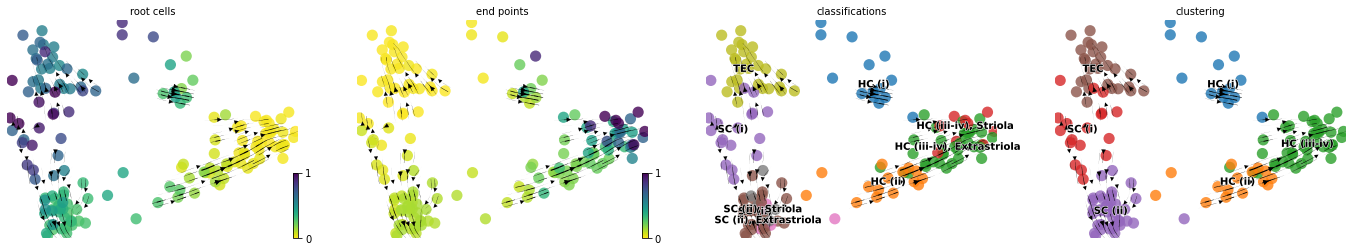

In [6]:
scv.tl.velocity_embedding(adata, basis='pca')

scv.pl.velocity_embedding_stream(adata, basis='pca', color=['root_cells', 'end_points', 'classifications', 'clustering'],
                                             ncols=4, legend_loc='on data', size=500, alpha=0.8)

In [7]:
# Simulate markov chains with default params
cytopath.sampling(adata, cluster_key='clustering', num_cores=os.cpu_count()-1)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 1098
Number of initial simulations (sim_number) set to 1098
Number of initial simulation steps (max_steps) set to 11

Sampling round: 0


  0%|          | 0/4 [00:00<?, ?it/s]

32.06 % of required simulations obtained for lagging end point HC (iii-iv). This is less than min_sim_ratio.
8.0146 % of simulations reached atleast one endpoint. Increasing number of simulation steps to 15.

Sampling round: 1


  0%|          | 0/4 [00:00<?, ?it/s]

44.81 % of required simulations obtained for lagging end point HC (iii-iv). This is less than min_sim_ratio.
11.2022 % of simulations reached atleast one endpoint. Increasing number of simulation steps to 18.

Sampling round: 2


  0%|          | 0/4 [00:00<?, ?it/s]

46.72 % of required simulations obtained for lagging end point HC (iii-iv). This is less than min_sim_ratio.
11.6803 % of simulations reached atleast one endpoint. Increasing number of simulation steps to 21.

Sampling round: 3


  0%|          | 0/4 [00:00<?, ?it/s]

52.82 % of required simulations obtained for lagging end point HC (iii-iv). This is less than min_sim_ratio.
13.2058 % of simulations reached atleast one endpoint. Increasing number of simulation steps to 23.

Sampling round: 4


  0%|          | 0/4 [00:00<?, ?it/s]

60.66 % of required simulations obtained for lagging end point HC (iii-iv).
15.1639 % of simulations reached atleast one endpoint. Generating 1098 additional samples.

Sampling round: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Sampling done.


In [8]:
# Infer trajectories with default params
cytopath.trajectories(adata, basis='pca',num_cores=os.cpu_count()-1)

Stage 1 clustering done. Aligning clusters for end point HC (iii-iv)
Calculating hausdorff distances


  0%|          | 0/1098 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/18 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point HC (iii-iv)


  0%|          | 0/18 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/2 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point HC (iii-iv) at each step


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  HC (iii-iv)


  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  HC (iii-iv) (i.e. cells neighborhood)


  0%|          | 0/2 [00:00<?, ?it/s]

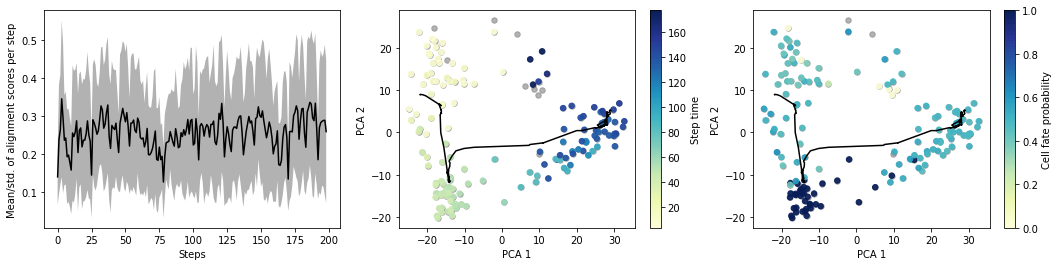

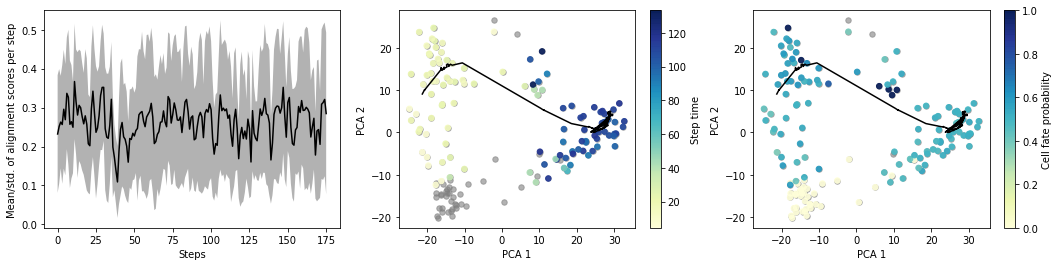

In [9]:
# Plot allignment and trajectories
cytopath.plot_trajectories(adata, directory='', basis='pca', smoothing=False, size=30, figsize=(18,4))

(-27.599438095092772,
 35.54768028259277,
 -22.486886310577393,
 28.808764743804932)

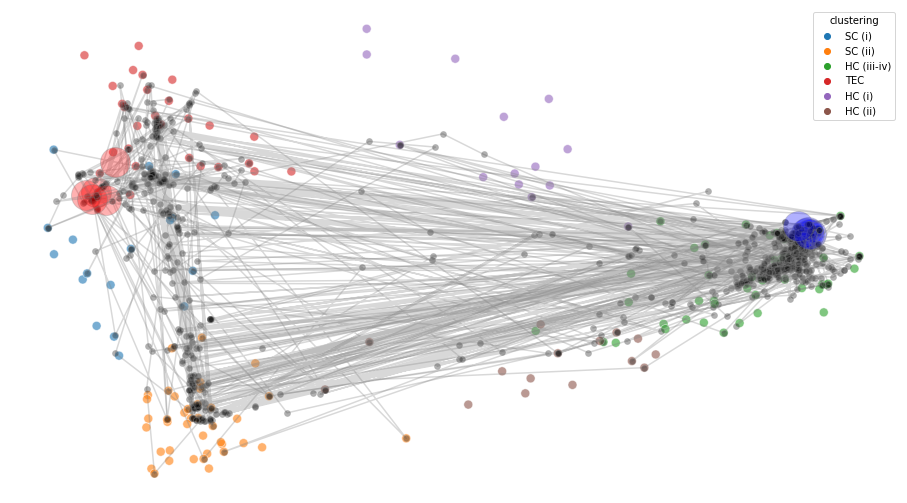

In [10]:
# subtrajectory red circles (start), blue circles (end) black dots (steps)
subtraj_data = pd.DataFrame(adata.uns['subtrajectories']['subtrajectory_coordinates']['HC (iii-iv)'])
plt.figure(figsize=(16,9))
sns.scatterplot(adata.obsm["X_pca"][:,0], adata.obsm["X_pca"][:,1],hue = adata.obs.clustering.astype(str),
                            s = 80, alpha=0.6)
for subtraj in subtraj_data['Subtrajectory'].unique():
    temp = subtraj_data.loc[subtraj_data['Subtrajectory'] == subtraj].sort_values('Step')
    plt.plot(temp.values[0,0], temp.values[0,1], '-o', color='grey', alpha=0.3, ms=30, markerfacecolor='red')
    plt.plot(temp.values[1:,0], temp.values[1:,1], '-o', color='grey', alpha=0.3, markerfacecolor='black')
    plt.plot(temp.values[-1,0], temp.values[-1,1], '-o', color='grey', alpha=0.3,ms=30, markerfacecolor='blue')
plt.axis('off')